In [3]:
pip install timm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 33.4 MB/s 
     |████████████████████████████████| 182 kB 87.4 MB/s 


In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import cv2
from torchvision import models, transforms
from timm.models.vision_transformer import vit_large_patch16_384
from timm.models import create_model, resume_checkpoint, convert_splitbn_model

In [5]:
model = create_model(
        'vit_large_patch16_384', 
        pretrained=True,
        num_classes=1000)

In [6]:
block_weights = [] # we will save the conv layer weights in this list
block_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(model.children())

In [7]:
all_block = []  # put all sub block in the list
for model_child in list(model.children()):
    if type(model_child) != torch.nn.modules.container.ModuleList:
        all_block.append(model_child)
    else:
        sub_children = list(model_child.children())
        for sub_child in sub_children:
            all_block.append(sub_child)

In [10]:
!git clone https://github.com/yitu-opensource/T2T-ViT

Cloning into 'T2T-ViT'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 213 (delta 72), reused 44 (delta 38), pack-reused 128
Receiving objects: 100% (213/213), 15.53 MiB | 15.74 MiB/s, done.
Resolving deltas: 100% (122/122), done.


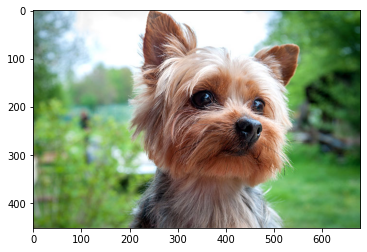

torch.Size([3, 384, 384])
torch.Size([1, 3, 384, 384])


In [13]:
# read and visualize an image
img = cv2.imread("/content/T2T-ViT/images/dog.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
# define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((384,384)),  # reszie the image as (1024, 1024) or (2048, 2048) to obtain high resolution features if you have large CPU or GPU memory
    transforms.ToTensor(),
])
img = np.array(img)
# apply the transforms
img = transform(img)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())

In [14]:
# pass the image through all the layers
results = []
results = [all_block[0](img)]
for i in range(1, len(all_block)-2):
    # pass the result from the last layer to the next layer
    #print(i)
    results.append(all_block[i](results[-1]))
# make a copy of the `results`
outputs = results

In [22]:
mkdir data

Saving layer 0 feature maps...


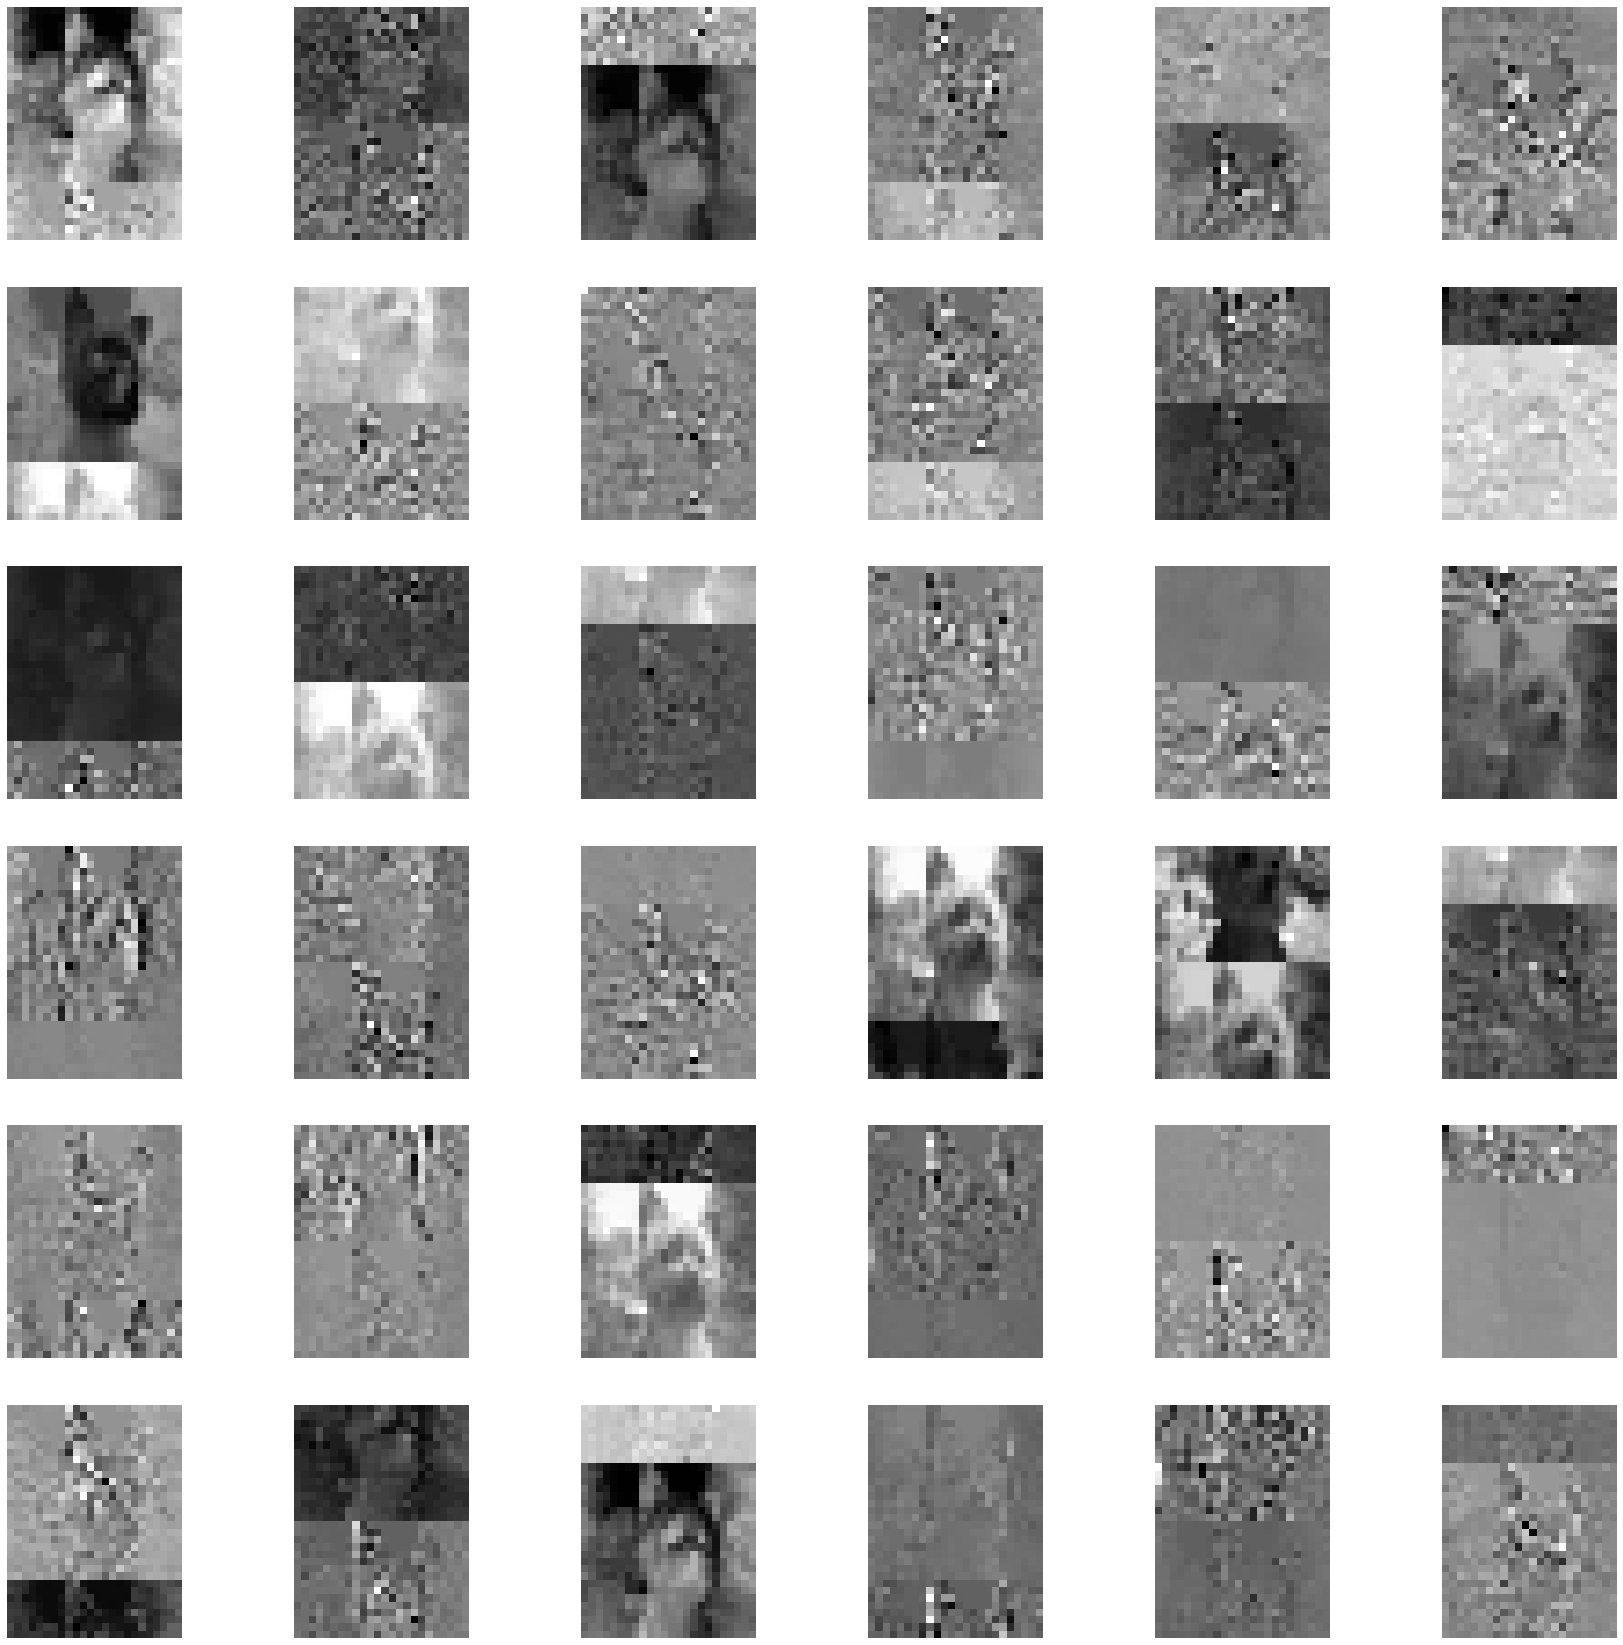

Saving layer 1 feature maps...


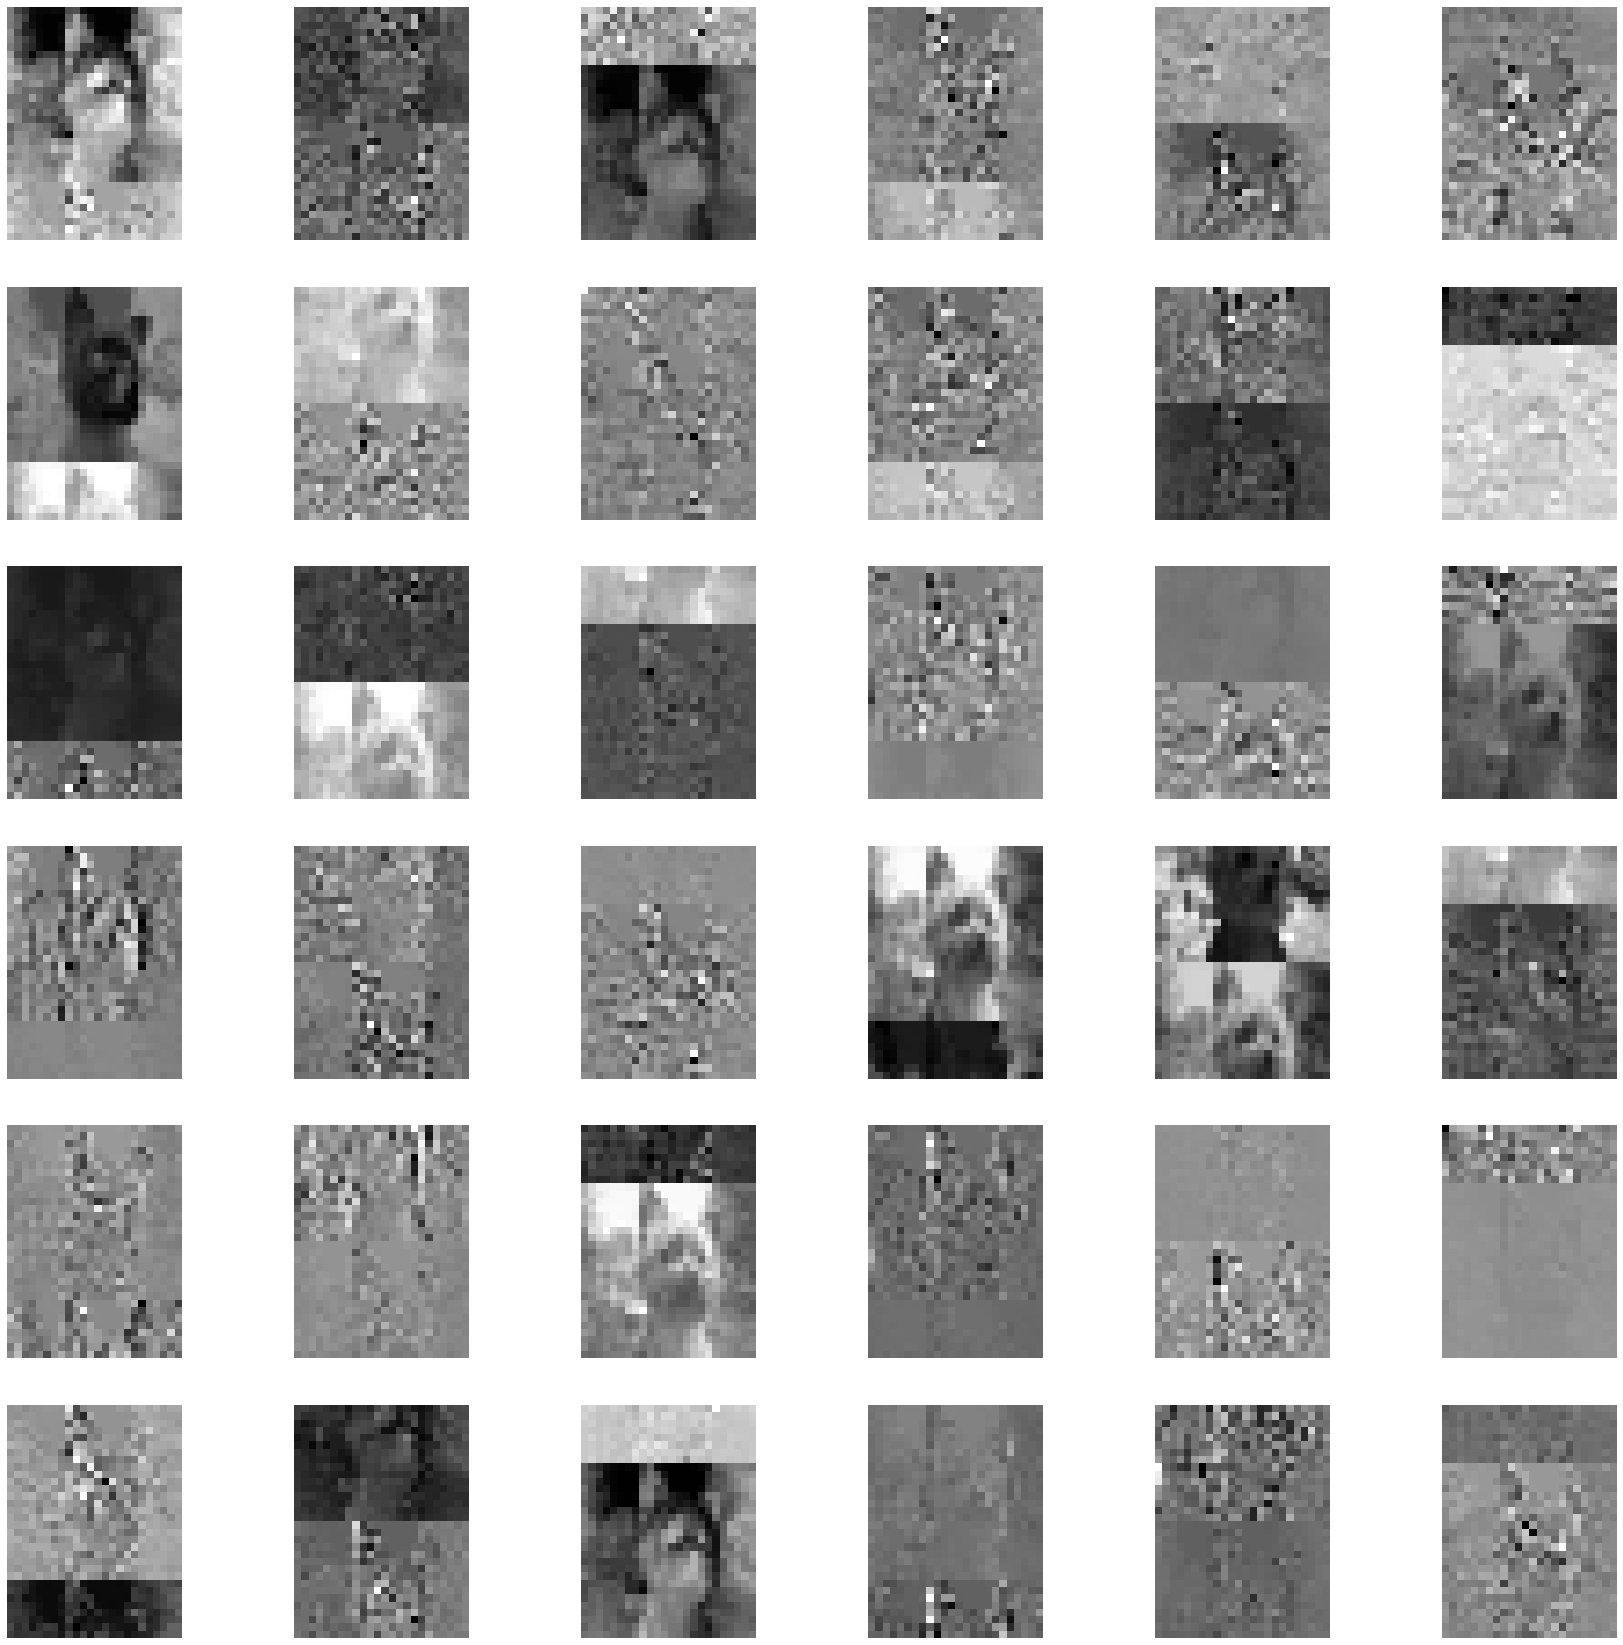

Saving layer 2 feature maps...


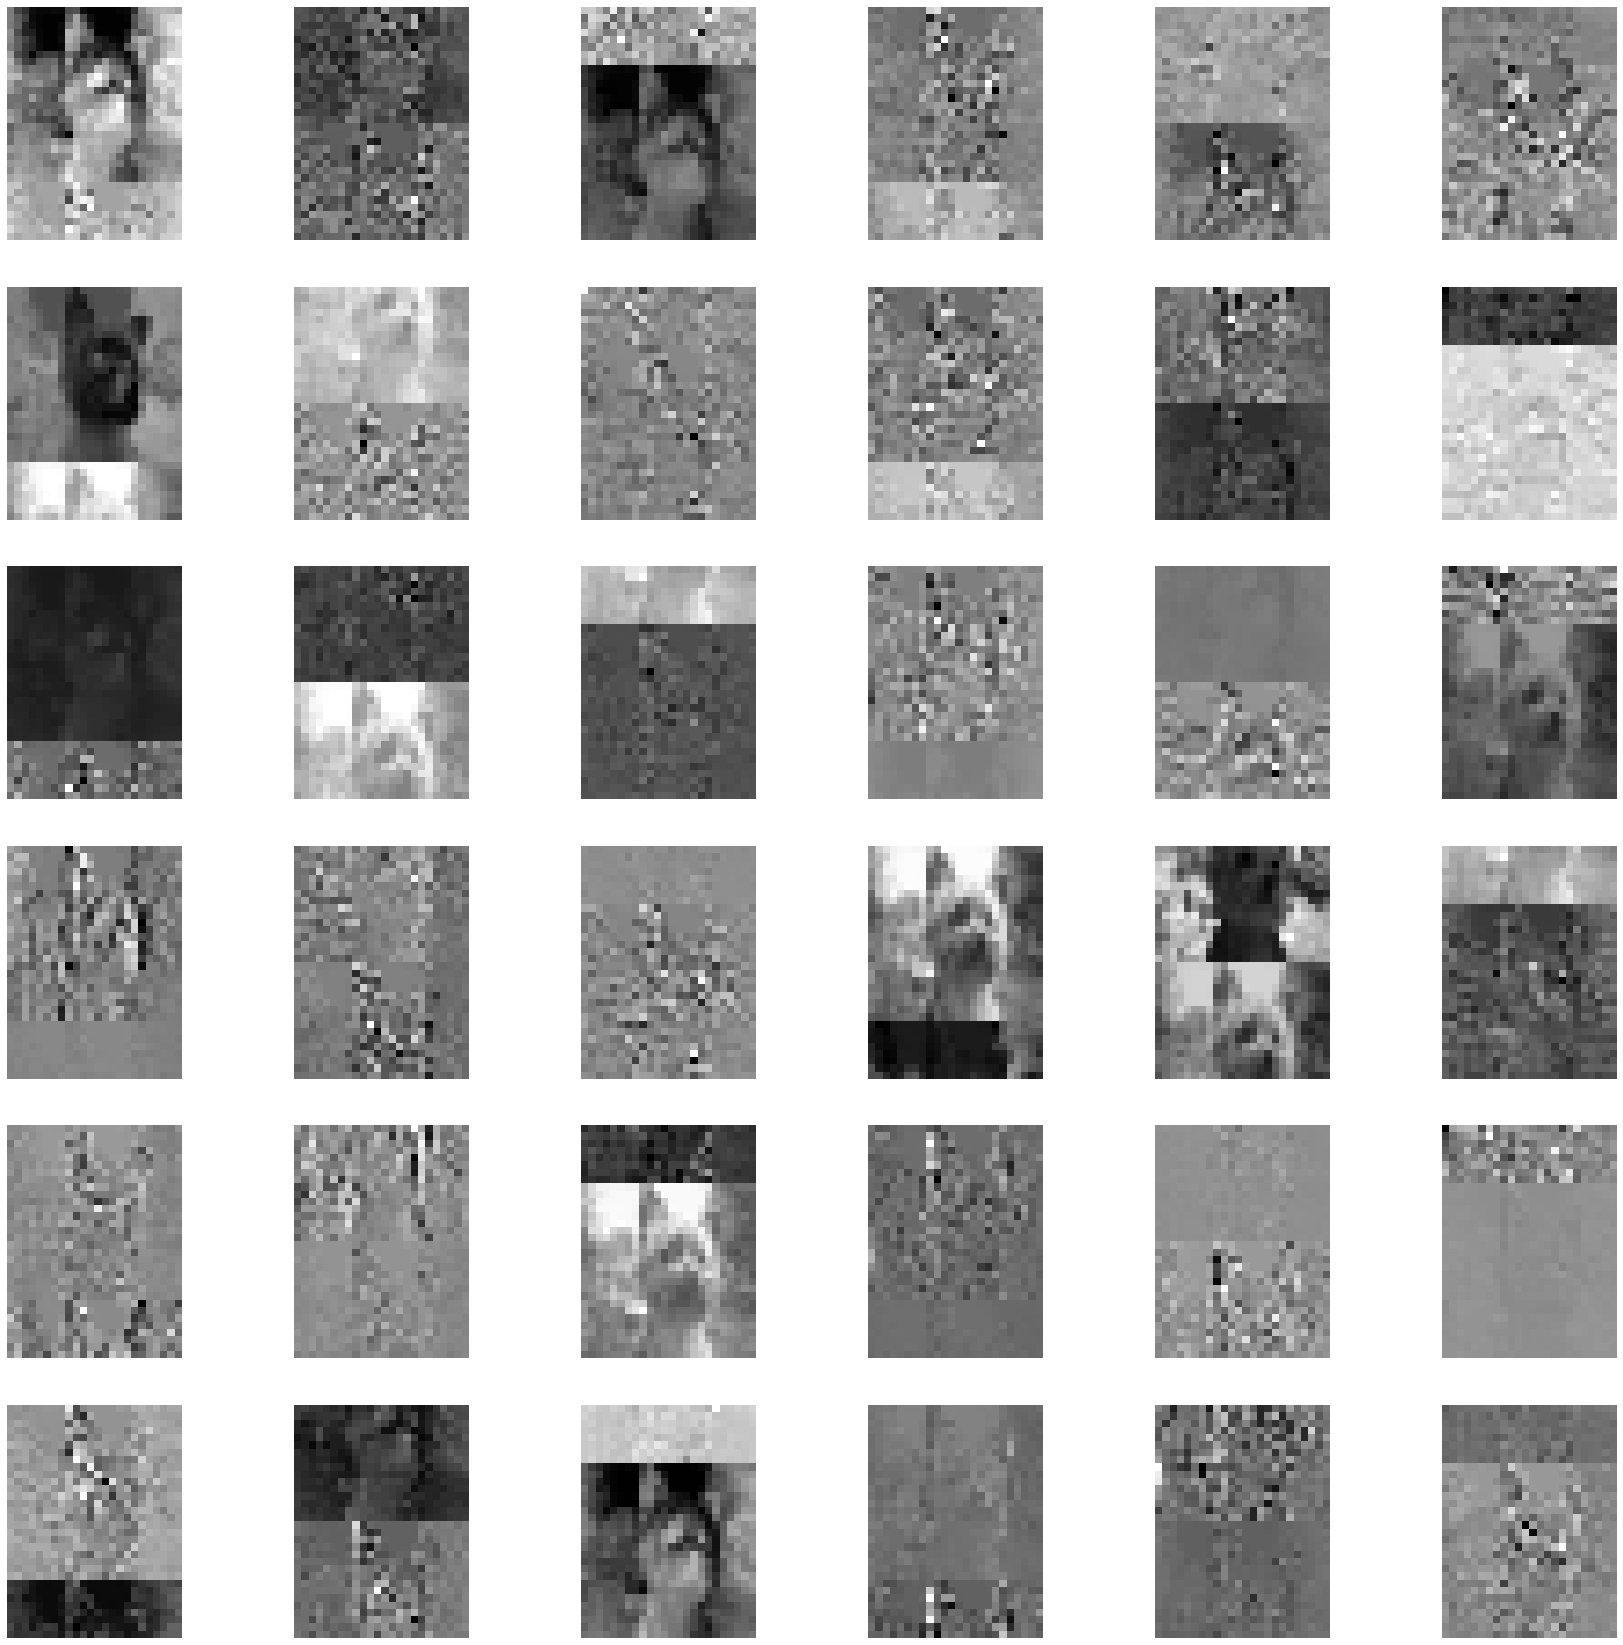

Saving layer 3 feature maps...


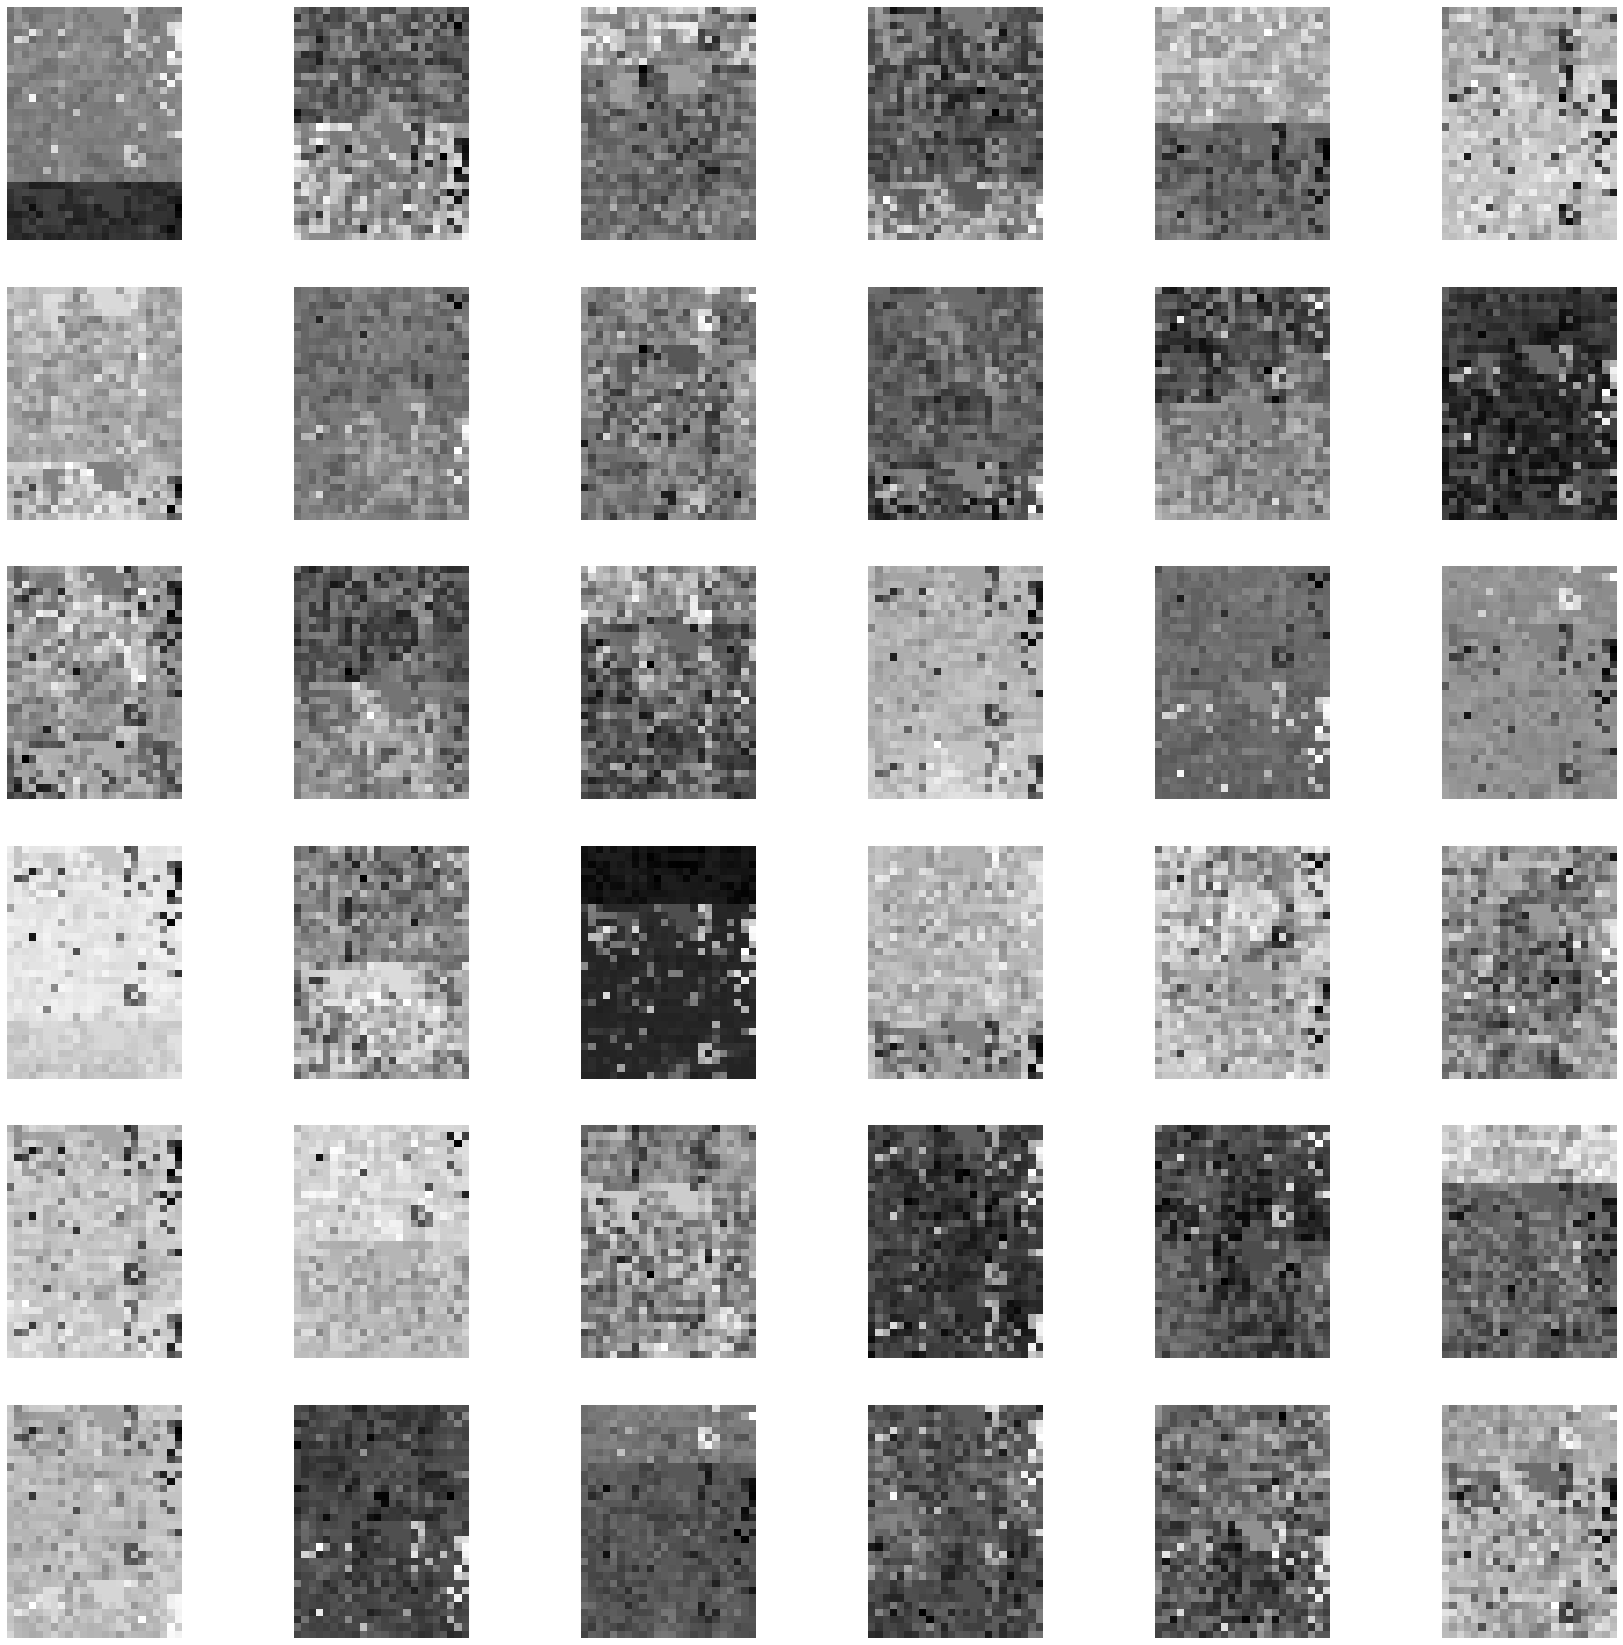

Saving layer 4 feature maps...


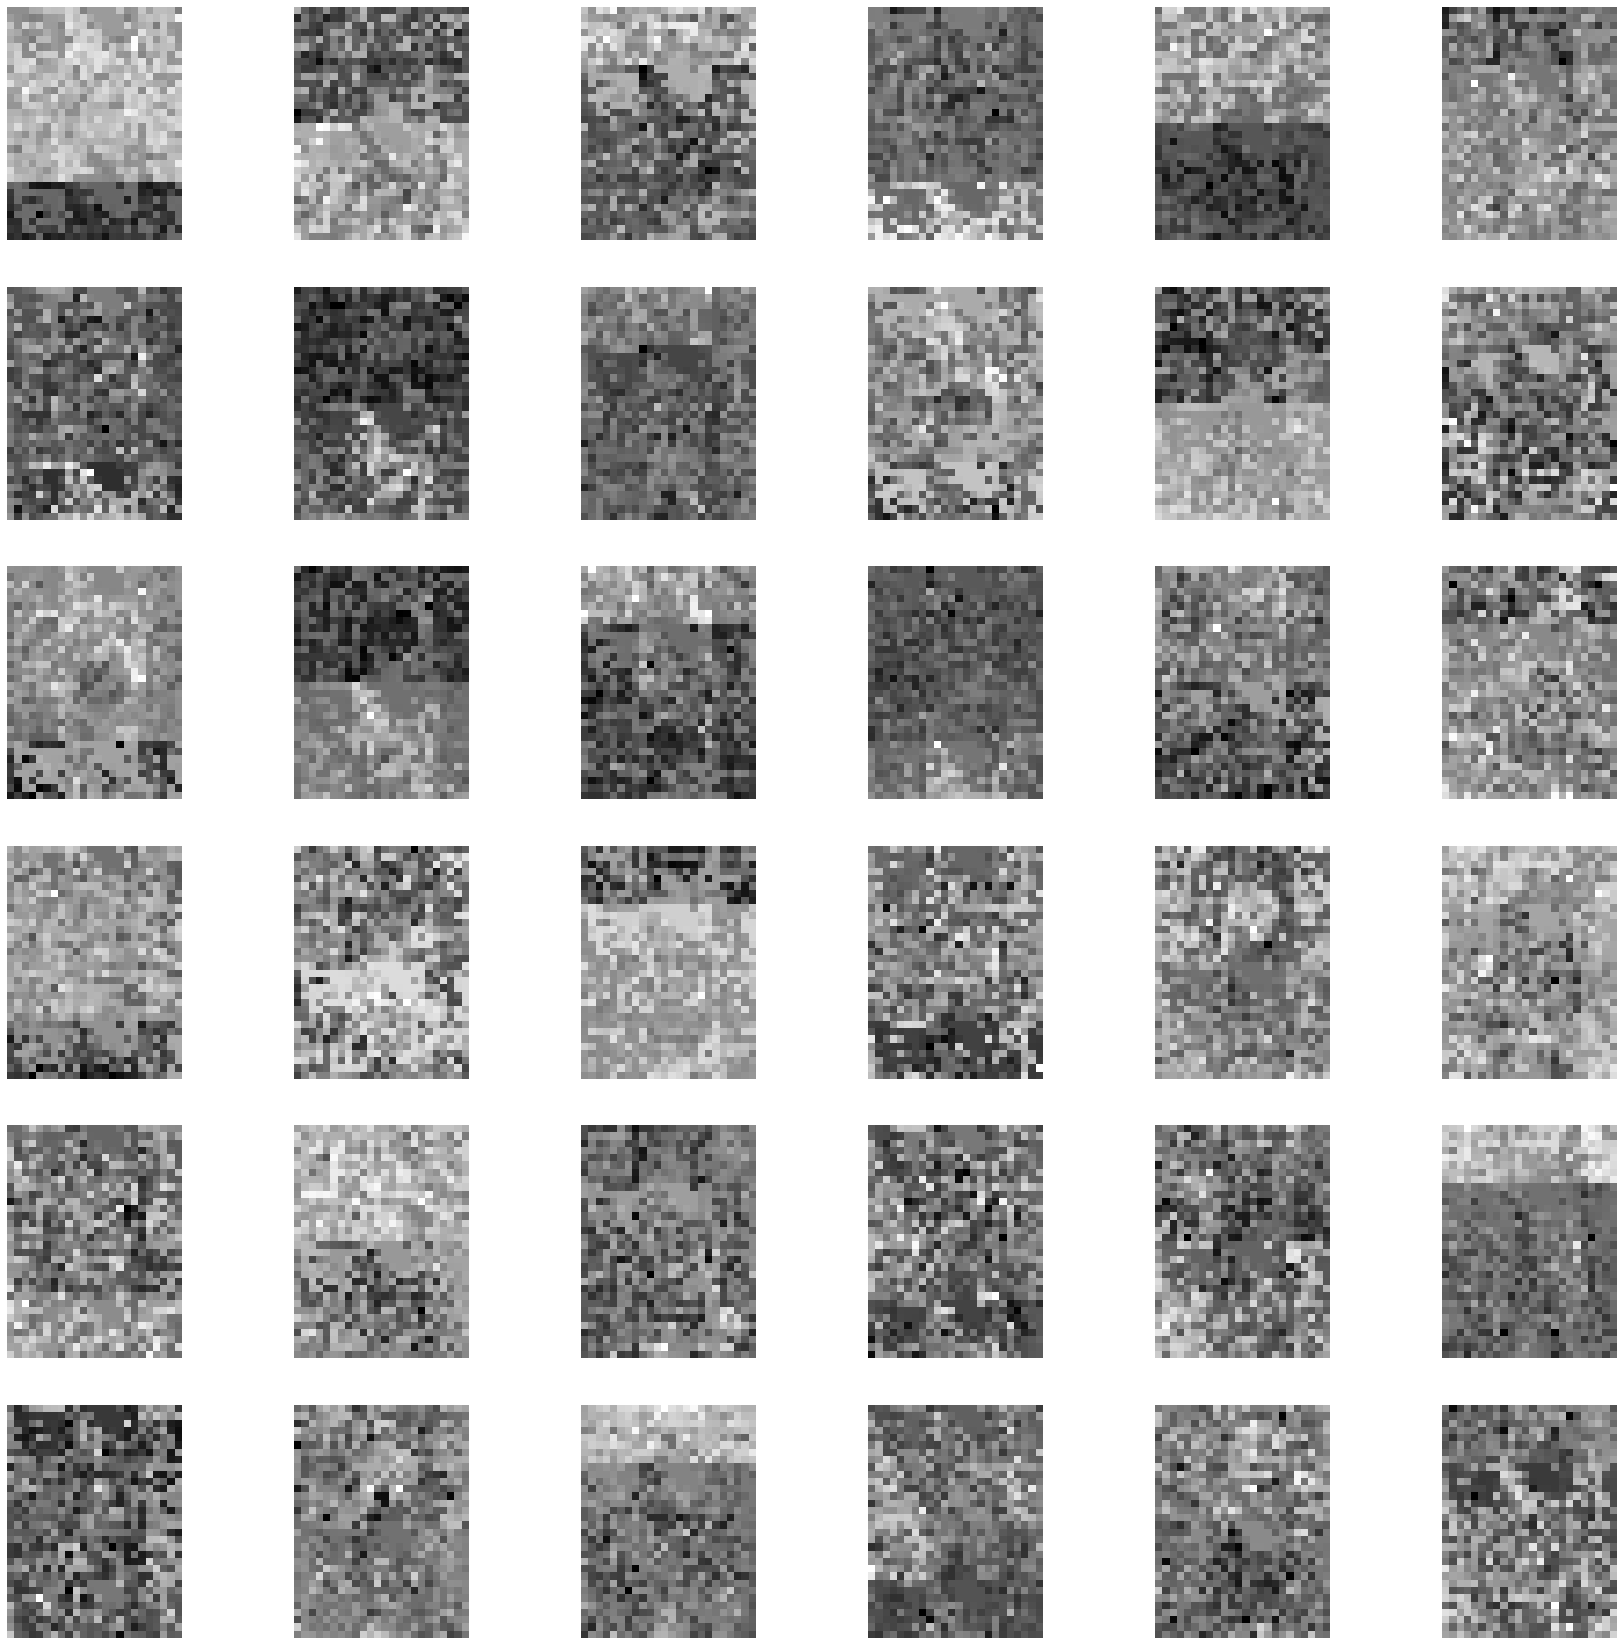

In [25]:
# visualize 36 features from each layer 
# (although there are more feature maps in the upper layers)
all_layers_num = 5   # change the number of length to control how many layers you want to visualize
for num_layer in range(all_layers_num): 
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer]#[0, :, :, :]
    layer_viz = layer_viz.data
    layer_viz = layer_viz.squeeze(0).transpose(0, 1)
    layer_viz = layer_viz.reshape(768, 32, 24)  # chage the reshape here
    #print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 36: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(6, 6, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    print(f"Saving layer {num_layer} feature maps...")
    plt.show() # use this line to show the figure in jupyter notebook
    plt.close()